**Rozdział 18. Uczenie przez wzmacnianie**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 18._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Uruchom w Google Colab (wersja angielska)</a>
  </td>
</table>

# Konfiguracja

Importujmy najpierw kilka popularnych modułów, upewnijmy się, że będą wstawiane wykresy MatplotLib, a także przygotujmy funkcję zapisującą rysunki. Sprawdzimy także, czy jest zainstalowane środowisko Python 3.5 lub nowsze (możliwe, że kod będzie działał w środowisku Python 2.x, zostało ono jednak porzucone, dlatego zalecamy korzystanie ze środowiska Python 3), a także biblioteka Scikit-Learn 0.20 lub nowsza i TensorFlow 2.0 lub nowszy.

In [3]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version istnieje jedynie w środowisku Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# Wymagany moduł TensorFlow ≥2.0
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("Nie wykryto procesora graficznego. Bez niego sieci splotowe mogą działać bardzo powoli.")
    if IS_COLAB:
        print("Kliknij Runtime > Change runtime i wybierz akcelerator graficzny.")

# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)
tf.random.set_seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Aby uzyskać płynne animacje
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R18"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow 2.x selected.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [83.6 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:14 http://archive.ubuntu.com/ubuntu

# Wprowadzenie do narzędzia OpenAI gym

W tym notatniku będziemy korzystać ze znakomitego zestawu narzędzi [OpenAI gym](https://gym.openai.com/), pozwalajacego na tworzenie i porównywanie algorytmów uczenia przez wzmacnianie. Zawiera on wiele środowisk, do których dostosowują się *agenty* uczenia. Zacznijmy od importowania modułu `gym`:

In [0]:
import gym

Wyświetlmy listę wszystkich dostępnych środowisk:

In [5]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

Cart-Pole jest bardzo prostym środowiskiem składającym się z poruszającego się w lewo lub w prawo wózka, na którym umieszczono ustawiony pionowo maszt. Agent musi tak przesuwać wózek, aby utrzymywać maszt w pionie.

In [6]:
env = gym.make('CartPole-v1')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Zainicjalizujmy środowisko poprzez wywołanie metody `reset()`. Zostaje zwrócona obserwacja:

In [0]:
env.seed(42)
obs = env.reset()

Istnieją różne obserwacje w zależności od środowiska. W naszym przypadku mamy do czynienia z jednowymiarową tablicą NumPy, składającą się z czterech wartości zmiennoprzecinkowych: reprezentują one położenie wózka, jego prędkość, kąt nachylenia masztu (0 = stoi pionowo) i jego prędkość kątową.

In [8]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

Możemy zwizualizować środowisko za pomocą metody `render()` i możesz wybrać tryb wyświetlania (zależnie od środowiska).

**Ostrzeżenie**: niektóre środowiska (takie jak Cart-Pole) wymagają dostępu do wyświetlacza i zostają otwarte w osobnym oknie, nawet jeśli wyznaczysz parametr `mode="rgb_array"`. Zasadniczo możesz spokojnie ignorować to okno. Jeśli jednak środowisko Jupyter jest uruchomienie na serwerze bezobsługowym (pozbawionym ekranu), zostanie wyświetlony komunikat o wyjątku. Jednym ze sposób rozwiązania tego problemu jest zainstalowanie fałszywego serwera X, takiego jak [Xvfb](http://en.wikipedia.org/wiki/Xvfb). W dystrybucjach Debian lub Ubuntu:

```bash
$ apt update
$ apt install -y xvfb
```

Możesz następnie uruchomić Jupyter za pomocą polecenia `xvfb-run`:

```bash
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

Ewentualnie możesz zainstalować bibliotekę [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay), zawierającą serwer Xvfb:

```bash
python3 -m pip install -U pyvirtualdisplay
```

Uruchom teraz poniższy kod:

In [9]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [10]:
env.render()

True

W tym przykładzie wyznaczymy `mode="rgb_array"`, aby uzyskać obraz środowiska jako tablicę NumPy:

In [11]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [0]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

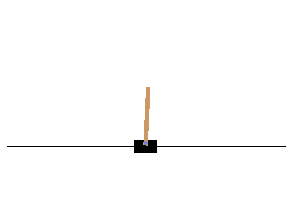

In [13]:
plot_environment(env)
plt.show()

Nauczmy się oddziaływać ze środowiskiem. Twój agent będzie musiał wybierać czynność z "przestrzeni czynności" (zbioru możliwych czynności). Sprawdźmy, jak wygląda przestrzeń czynności w omawianym środowisku:

In [14]:
env.action_space

Discrete(2)

No tak, dysponujemy dwiema możliwymi czynnościami: przyspieszanie w lewo lub w prawo.

Maszt przechyla się w prawo (`obs[2] > 0`), dlatego przyspieszmy wózek w prawo:

In [15]:
action = 1  # przyspiesza w prawo
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

Zwróć uwagę, że wózek porusza się teraz w prawo (`obs[1] > 0`). Masz nadal chyli się ku prawej (`obs[2] > 0`), ale teraz jego prędkość kątowa jest ujemna (`obs[3] < 0`), więc prawdopodobnie w następnym kroku zacznie się przechylać w lewo.

Zapisywanie rysunku cart_pole


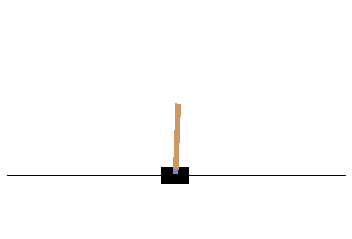

In [16]:
plot_environment(env)
save_fig("cart_pole")

Wygląda na to, że wszystko działa tak, jak powinno!

Środowisko informuje także agenta o nagrodzie otrzymanej w poprzednim kroku:

In [17]:
reward

1.0

Po zakończeniu gry środowisko zwraca `done=True`:

In [18]:
done

False

Mamy również do dyspozycji słownik `info`, który, w zależności od środowiska, może zawierać informacje przydatne do usuwania błędów lub uczenia modelu. Na przykład w wielu grach określa ono liczbę żyć posiadanych przez agenta.

In [19]:
info

{}

Sekwencja kroków od momentu wyzerowania środowiska do zakończenia gry jest nazywana "epizodem". Na koniec epizodu (gdy metoda `step()` zwraca `done=True`), należy zresetować środowisko przed jego ponownym wykorzystaniem.

In [0]:
if done:
    obs = env.reset()

Jak sprawić, żeby maszt pozostał w pozycji pionowej? Musimy zdefiniować odpowiednią _politykę_. Jest to strategia, której agent będzie używał do wybierania czynności w każdym kroku. Aby podjąć decyzję, może korzystać ze wszystkich przeszłych czynności i obserwacji.

# Prosta, ręcznie zaprogramowana polityka

Zaprogramujmy ręcznie prostą strategię: jeśli maszt będzie przechylać się w lewo, popchnijmy wózek w lewo i odwrotnie. Zobaczmy, jak się sprawuje takie rozwiązanie:

In [0]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [22]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

Jak można było przewidzieć, ta strategia jest nieco zbyt prosta: w najlepszym epizodzie agent zdołał utrzymać maszt pionowo jedynie przez 68 kroków. Zadanie zostaje uznane za wykonane, jeśli agent utrzyma maszt w pionie przez 200 kroków.

Wyświetlmy jeden epizod:

In [0]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

A teraz wyświetlmy animację:

In [0]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [25]:
plot_animation(frames)

Najwyraźniej system okazuje się zbyt niestabilny i już po kilku krokach maszt jest zbyt rozchybotany: koniec gry. Musimy ruszyć głową!

# Polityki w postaci sieci neuronowych

Stwórzmy sieć neuronową, dla której obserwacje będą danymi wejściowymi i która na wyjściu określi czynność, jaka ma zostać wykonana dla każdej obserwacji. W celu wybrania czynności sieć najpierw oszacuje prawdopodobieństwo wystąpienia każdej z nich, a następnie losowo dobierze czynność na podstawie tych oszacowanych prawdopodobieństw. W przypadku środowiska Cart-Pole dostępne są tylko dwie możliwe czynności (ruch w lewo lub w prawo), zatem będzie nam potrzebny tylko jeden neuron wyjściowy: będzie on dawał na wyjściu prawdopodobieństwo `p` użycia czynności 0 (ruch w lewo), oraz, oczywiście, prawdopodobieństwo użycia czynności 1, określanego wzorem `1 - p`.

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

W tym konkretnym środowisku możemy spokojnie ignorować poprzednie czynności i obserwacje, ponieważ każda obserwacja w pełni opisuje stan środowiska. Gdyby istniał jakiś ukryty stan, to w celu próby wzięcia go pod uwagę musielibyśmy analizować również wcześniejsze czynności i obserwacje. Na przykład gdyby środowisko informowało jedynie o położeniu, ale nie prędkości wózka, musielibyśmy uwzględniać nie tylko bieżącą, ale również poprzednią obserwację w celu oszacowania jego bieżącej prędkości. Inny przykład stanowią zaszumione dane: w celu określenie najbardziej prawdopodobnego bieżącego stanu musielibyśmy wziąć pod uwagę kilka wcześniejszych obserwacji. Z tego wynika, że problem określony w środowisku CartPole jest najprostszy z możliwych; obserwacje nie zawierają szumu, za to przechowują pełen stan środowiska.

Pewnie zastanawiasz się, dlaczego wybieramy losowe działanie bazując na prawdopodobieństwie wyliczonym przez sieć neuronową zamiast po prostu dobrać działanie, które uzyskało najwyższy wynik. Dzięki takiemu podejściu agent jest w stanie zachować właściwą równowagę pomiędzy _poszukiwaniem_ nowych działań a _wykorzystywaniem_ już znanych i sprawdzonych. Posłużmy się analogią: załóżmy, że idziesz pierwszy raz w życiu do restauracji i wszystkie dania wyglądają równie apetycznie, dlatego zamawiasz losowo jedno z nich. Jeśli okaże się smaczne, to zwiększa się prawdopodobieństwo, że wybierzesz je znowu, ale wartość tego prawdopodobieństwa nigdy nie osiąga 100%, gdyż w przeciwnym razie nigdy nie zaryzykowałabyś/zaryzykowałbyś zamówienia innej potrawy, która mogłaby okazać się jeszcze smaczniejsza.

Napiszmy małą funkcję, dzięki której model rozegra jeden epizod i zwróci klatki, które następnie wyświetlimy jako animację:

In [0]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

Sprawdźmy, jak sobie poradziła ta losowo zainicjalizowana polityka:

In [28]:
frames = render_policy_net(model)
plot_animation(frames)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


No tak... całkiem kiepsko. Sieć neuronowa musi nauczyć się radzić sobie lepiej. Sprawdźmy najpierw, czy jest w stanie nauczyć się wcześniej zdefiniowanej podstawowej polityki: ruchu w lewo gdy maszt przechyla się w prawo i ruchu w prawo, gdy przechyla się w prawo.

Możemy sprawić, aby ta sama sieć grała równocześnie w 50 różnych środowiskach (dzięki temu uzyskamy zróżnicowaną grupę uczenia w każdym kroku) i przeprowadzić proces uczenia przez 5000 iteracji. Do tego zresetujemy środowiska po zakończeniu uczenia. Trenujemy model za pomocą niestandardowej pętli uczenia, dzięki czemu możemy z łatwością wykorzystywać prognozy z każdego kroku uczenia do uzyskiwania postępów.

In [29]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # jeżeli angle < 0, to chcemy proba(left) = 1., a w przeciwnym wypadku proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteracja numer {}, Funkcja straty: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Iteracja numer 4999, Funkcja straty: 0.094

In [30]:
frames = render_policy_net(model)
plot_animation(frames)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Wygląda na to, że model nauczył się polityki we właściwy sposób. Zobaczmy, czy jest on w stanie samodzielnie wyuczyć się lepszej polityki. Takiej, w której maszt nie będzie taki rozchybotany.

# Gradienty polityk

W celu wyuczenia tej sieci neuronowej musimy zdefiniować docelowe prawdopodobieństwa `y`. Jeżeli czynność jest dobra, powinniśmy zwiększyć prawdopodobieństwo jej wystąpienia i odwrotnie. Skąd jednak mamy wiedzieć, czy dana czynność jest dobra lub zła? Problem polega na tym, że konsekwencje wielu czynności pojawiają się dopiero po pewnym czasie, dlatego w przypadku zdobywania lub utraty punktów w grze nie jest jasne, które czynności przyczyniły się do danego wyniku: czy jest za to odpowiedzialna ostatnia czynność? A może 10 ostatnich czynności? Albo jedna czynność sprzed 50 kroków? Jest to tak zwany _problem przypisania zasługi_.

Algorytm _gradientów polityk_ rozwiązuje ten problem najpierw przeprowadzając wiele rozgrywek, następnie nieznacznie zwiększając prawdopodobieństwo występowania dobrych czynności przy jednoczesnym delikatnym redukowaniu prawdopodobieństwa występowania złych czynności. Najpierw gramy, a później wracamy do początku partii i zastanawiamy się nad swoimi ruchami.

Zacznijmy od stworzenia funkcji, dzięki której zostanie rozegrany jeden krok. Na razie będzie także udawać, że każda wybrana czynność będzie właściwa, co pozwoli obliczyć funkcję straty i jej gradienty (na razie zapiszemy te gradienty, a później je zmodyfikujemy w zależności od tego, jak dobra okazała się dana czynność):

In [0]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

Jeżeli `left_proba` ma dużą wartość, to `action` będzie miała najprawdopodbniej wartość `False` (gdyż liczba losowa jednostajnie wylosowana z przedziału pomiędzy 0 a 1 nigdy nie będzie większa od `left_proba`). Wartość `False` przełożona na wartość liczbową jest równa 0, zatem `y_target` byłoby równe 1 - 0 = 1. Inaczej mówiąc, wyznaczamy wartość docelową równą 1, co oznacza udawanie, że prawdopdopodobieństwo ruchu w lewo powinno być równe 100% (zatem wykonaliśmy właściwą czynność).

Stwórzmy kolejną funkcję, która będzie polegała na funkcji `play_one_step()`, rozgrywała wiele epizodów, a także zwracała wszystkie nagrody i gradienty z każdego epizodu i kroku:

In [0]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

Algorytm gradientów polityk wykorzystuje model do kilkukrotnego rozgrywania epizodu (na przykład dziesięć razy), następnie analizuje uzyskane nagrody, które następnie zmniejsza i normalizuje. Stwórzmy w tym celu dwie funkcje: pierwsza z nich będzie obliczała nagrody dyskontowe; druga przeprowadzi normalizację nagród dyskontowych w wielu epizodach.

In [0]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Załóżmy, że występują trzy czynności, a każda z nich gwarantuje jakąś nagrodę: pierwsza +10, druga 0, a trzecia -50. Jeżeli skorzystamy ze stopy dyskontowej rzędu 80%, to z trzeciej czynności otrzymamy nagrodę -50 (pełna wartość za najnowszą czynność), ale druga czynność da zaledwie nagrodę -40 (80% z ostatniej nagrody), a pierwsza czynność pozwoli uzyskać nagrodę stanowiącą 80% z -40 (-32), a do tego pełną wartość pierwszej nagrody (+10), co prowadzi do nagrody dyskontowej równej -22:

In [34]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

Aby znormalizować wszystkie nagrody dyskontowe we wszystkich epizodach, obliczamy średnią i odchylenie standardowe wszystkich nagród dyskontowych, po czym od każdej z tych nagród odejmujemy tę średnią i dzielimy je przez odchylenie standardowe:

In [35]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [0]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [0]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [39]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Nieukazane w książce
    print("\rIteracja numer {}, średnie nagrody: {:.1f}".format(   # Nieukazane
        iteration, total_rewards / n_episodes_per_update), end="") # Nieukazane
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Iteracja numer 149, średnie nagrody: 178.3

In [40]:
frames = render_policy_net(model)
plot_animation(frames)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Łańcuchy Markowa

In [41]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("Stany:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

Stany: 0 0 3 
Stany: 0 1 2 1 2 1 2 1 2 1 3 
Stany: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Stany: 0 3 
Stany: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Stany: 0 1 3 
Stany: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
Stany: 0 0 3 
Stany: 0 0 0 1 2 1 2 1 3 
Stany: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


# Procesy decyzyjne Markowa

Zdefiniujmy prawdopodobieństwa przejścia, nagrody i możliwe czynności. Na przykład jeżeli w stanie s0 zostanie wybrana czynność a0, to będzie istnieć 70% prawdopodobieństwo, że agent przejdzie do stanu s0 z nagrodą +10, 30%, że przejdzie do stanu s1 bez nagrody i 0%, że przejdzie do stanu s2 (czyli prawdopodobieństwa przejścia wynoszą `[0.7, 0.3, 0.0]`, a nagrody to `[+10, 0, 0]`):

In [0]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Algorytm iteracji Q-wartości

In [0]:
Q_values = np.full((3, 3), -np.inf) # -np.inf dla czynności niemożliwych
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # dla wszystkich możliwych czynności

In [0]:
gamma = 0.90  # stopa dyskontowa

history1 = [] # Nieukazane w książce (potrzebne do poniższego rysunku)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Nieukazane
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Nieukazane

In [45]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [46]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

Optymalną polityką w przypadku używania stopy dyskontowej równej 0,90 jest wybór czynności a0 w stanie s0, następnie wybór czynności a0 w stanie s1 i w końcu wybór czynności a1 (jedynej możliwej) w stanie s2.

Zwiększmy stopę dyskontową do wartości 0,95:

In [0]:
Q_values = np.full((3, 3), -np.inf) # -np.inf dla czynności niemożliwych
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # dla wszystkich możliwych czynności

In [0]:
gamma = 0.95  # stopa dyskontowa

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [49]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [50]:
np.argmax(Q_values, axis=1)

array([0, 2, 1])

Polityka uległa zmianie! Teraz w stanie s1 lepiej przejść przez płomienie (wybrać czynność a2). Wynika to z faktu, że stopa dyskontowa ma większą wartość, przez co agent bardziej zwraca uwagę na przyszłość i dlatego gotów jest na otrzymanie teraz kary po to, aby w przyszłości uzyskiwać lepsze nagrody.

# Algorytm Q-uczenia

Algorytm Q-uczenia działa poprzez obserwowanie gry agenta (losowej), a następnie stopniowe poprawianie oszacowań Q-wartości. Po uzyskaniu precyzyjnych (lub prawie precyzyjnych) oszacowań, zostaje wprowadzona optymalna polityka dobierająca czynności mającej największą Q-wartość (polityka zachłanna).

Musimy symulować agenta poruszającego się w obszarze środowiska, dlatego zdefiniujmy funkcję realizującą jakąś czynność, a następnie uzyskującą nowe stan i nagrodę:

In [0]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

Potrzebujemy także polityki poszukiwania, która może być dowolną polityką, dopóki odwiedza wielokrotnie każdy możliwy stan. Mamy do czynienia z bardzo małą przestrzenią stanów, dlatego wykorzystamy politykę losową:

In [0]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Zainicjalizujmy teraz Q-wartości tak jak robiliśmy to wcześniej i zrealizujmy algorytm Q-uczenia:

In [0]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # początkowy współczynnik uczenia
decay = 0.005 # współczynnik rozkładu współczynnika uczenia
gamma = 0.90 # stopa dyskontowa
state = 0 # stan początkowy
history2 = [] # Nieukazane w książce

for iteration in range(10000):
    history2.append(Q_values.copy()) # Nieukazane
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # polityka zachłanna w następnym kroku
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Nieukazane

In [54]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [55]:
np.argmax(Q_values, axis=1) # optymalna czynność dla każdego stanu

array([0, 0, 1])

Zapisywanie rysunku r_18_9


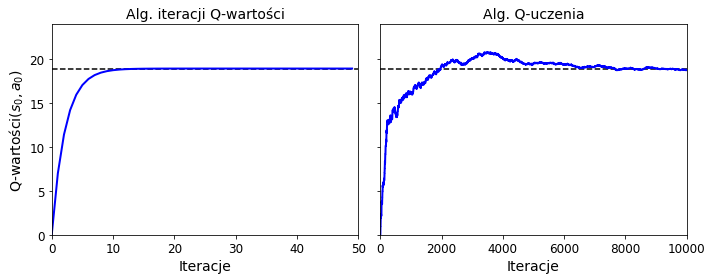

In [56]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-wartości$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Alg. iteracji Q-wartości", fontsize=14)
axes[1].set_title("Alg. Q-uczenia", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iteracje", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("r_18_9")

# Q-sieć głęboka

Stwórzmy sieć DQN. Dla danego stanu i wszystkich możliwych czynności będzie ona szacować sumę przyszłych nagród dyskontowych, jakich może oczekiwać po wykonaniu określowej czynności (ale przed jej poznaniem wyniku):

In [57]:
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Sieć ta będzie wybierać czynność o największej prognozowanej Q-wartości. Aby jednak sprawić, że agent będzie przeszukiwał środowisko, będzie wybierana losowa czynność z prawdopodobieństwem `epsilon`.

In [0]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

Potrzebna jest nam również pamięć odtwarzania. Będzie ona przechowywać doświadczenia agenta w formie krotek: `(obs, action, reward, next_obs, done)`. Możemy w tym celu użyć klasy `deque`:

In [0]:
from collections import deque

replay_memory = deque(maxlen=2000)

Stwórzmy funkcję losującą doświadczenia z pamięci odtwarzania. Będzie ona zwracała pięć tablic NumPy: `[obs, action, reward, next_obs, done]`.

In [0]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

Teraz możemy stworzyć funkcję wykorzystującą sieć DQN do rozgrywania jednego kroku i rejestrującą uzyskiwane doświadczenie w pamięci odtwarzania:

In [0]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Na koniec stworzymy funkcję pobierającą doświadczenia z pamięci odtwarzania i realizującą fazę uczenia:

In [0]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = rewards + (1 - dones) * discount_rate * max_next_Q_values
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Wytrenujmy teraz model!

In [0]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [64]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Nieukazane w książce
    if step > best_score: # Nieukazane
        best_weights = model.get_weights() # Nieukazane
        best_score = step # Nieukazane
    print("\rEpizod numer {}, Kroki: {}, epsilon: {:.3f}".format(episode, step + 1, epsilon), end="") # Nieukazane
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Epizod numer 51, Kroki: 11, epsilon: 0.898WARNING:tensorflow:Layer dense_4 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epizod numer 599, Kroki: 91, epsilon: 0.010

Zapisywanie rysunku r_18_10


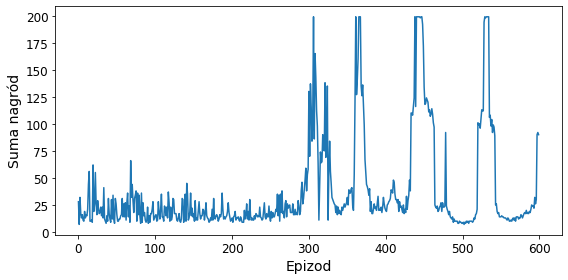

In [65]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Epizod", fontsize=14)
plt.ylabel("Suma nagród", fontsize=14)
save_fig("r_18_10")
plt.show()

In [66]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

Całkiem nieźle!

## Podwójna sieć DQN

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [0]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = rewards + (1 - dones) * discount_rate * next_best_Q_values
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [0]:
replay_memory = deque(maxlen=2000)

In [70]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpizod numer {}, Kroki: {}, epsilon {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 50 == 0:
        target.set_weights(model.get_weights())
    # Ewentualnie możesz przeprowadzać aktualizacje "miękkie" w każdym kroku: 
    #if episode > 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * target_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Epizod numer 51, Kroki: 11, epsilon 0.898WARNING:tensorflow:Layer dense_7 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epizod numer 599, Kroki: 12, epsilon 0.010

Zapisywanie rysunku podwojna_siec_DQN


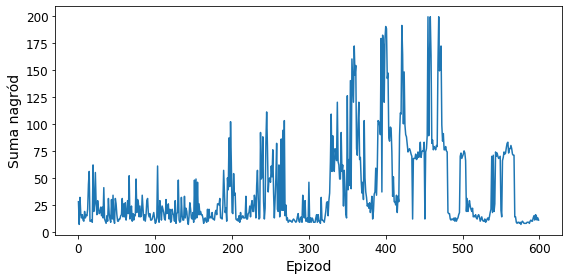

In [71]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Epizod", fontsize=14)
plt.ylabel("Suma nagród", fontsize=14)
save_fig("podwojna_siec_DQN")
plt.show()

In [72]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

# Walcząca, podwójna sieć DQN

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [0]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = rewards + (1 - dones) * discount_rate * next_best_Q_values
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [0]:
replay_memory = deque(maxlen=2000)

In [76]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpizod numer {}, Kroki: {}, epsilon: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Epizod numer 51, Kroki: 15, epsilon: 0.898WARNING:tensorflow:Layer dense_10 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFl

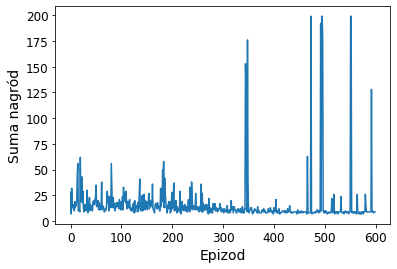

In [77]:
plt.plot(rewards)
plt.xlabel("Epizod")
plt.ylabel("Suma nagród")
plt.show()

In [78]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

Agent ten wydaje się być całkiem wszechstronny!

In [0]:
env.close()

# Używanie biblioteki TF-Agents do wygrania w grę Breakout

Za pomocą biblioteki TF-Agents stwórzmy agenta, który nauczy się grać w Breakout. Skorzystamy z algorytmu Q-uczenia głębokiego, dzięki czemu będziesz mógł z łatwością porównywać składniki opisane w powyższej implementacji, ale biblioteka TF-Agents zawiera wiele innych (i bardziej zaawansowanych) algorytmów!

## Środowiska TF-Agents

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

In [86]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [87]:
env.gym

In [83]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [88]:
env.step(1) # Przycisk Fire

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

Zapisywanie rysunku breakout_plot


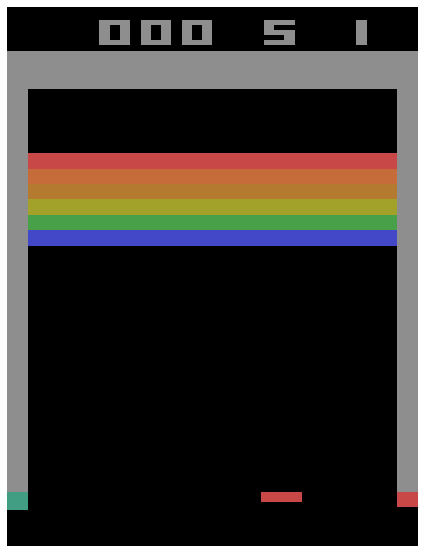

In [89]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [90]:
env.current_time_step()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

## Specyfikacje środowiska

In [91]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [92]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [93]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

## Funkcje otaczające środowisko

Możesz umieścić środowiska TF-Agents w funkcji otaczającej TF-Agents:

In [94]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [95]:
repeating_env.unwrapped

Oto lista dostępnych funkcji otaczających:

In [96]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapp

Funkcja `suite_gym.load()` może za nas tworzyć i otaczać środowisko; dotyczy to zarówno funkcji otaczających środowiska TF-Agents, jak środowiska Gym (te ostatnie są stosowane jako pierwsze).

In [0]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [98]:
limited_repeating_env

Stworzymy środowisko Atari Breakout i otoczymy je po to, aby można było przeprowadzić domyślne etapy przetwarzania wstępnego:

In [99]:
limited_repeating_env.unwrapped

In [0]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

In [113]:
env

Rozegrajmy kilka kroków i sprawdźmy, co się stanie:

In [0]:
env.seed(42)
env.reset()
time_step = env.step(1) # przycisk FIRE
for _ in range(4):
    time_step = env.step(3) # kierunek w lewo

In [0]:
def plot_observation(obs):
    # Występują tylko trzy kanały kolorów, dlatego nie możemy wyświetlać czterech klatek
    # poprzez wyznaczenie po jednym kolorze głównym na klatkę. Z tego powodu niniejszy kod oblicza wartość delta
    # pomiędzy ramką bieżącą a średnią z pozostałych ramek, po czym dodaje tę wartość delta
    # do kanałów czerwonego i niebieskiego, dzięki czemu otrzymujemy kolor różowy dla bieżącej klatki.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Zapisywanie rysunku r_18_12


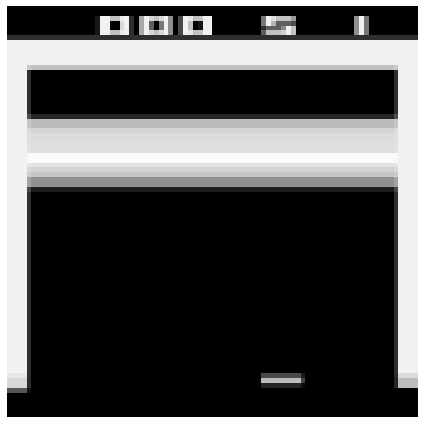

In [105]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("r_18_12")
plt.show()

Przekształcamy środowisko Python w środowisko TF:

In [0]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## Tworzenie sieci DQN

Stworzymy małą klasę normalizującą obserwacje. Obrazy są zapisywane w formie bajtowej w przedziale od 0 do 255 po to, aby zaoszczędzić pamięć operacyjną, ale my chcemy przekazywać wartości zmiennoprzecinkowe w zakresie od 0,0 do 1,0 na wejście sieci neuronowej:

Tworzymy Q-sieć:

In [0]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

Tworzymy agenta DQN:

In [0]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

# zobacz problem TF-agents #113
#optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
#                                     epsilon=0.00001, centered=True)

train_step = tf.Variable(0)
update_period = 4 # realizuje krok uczenia co cztery kroki zbierania
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # początkowa wartość ε
    decay_steps=250000 // update_period, # <=> 1 000 000 klatek ALE
    end_learning_rate=0.01) # końcowa wartość ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32 000 klatek ALE
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # stopa dyskontowa
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

Tworzymy bufor odtwarzania:

In [0]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=1000000)

replay_buffer_observer = replay_buffer.add_batch

Tworzymy prostego obserwatora niestandardowego, który zlicza i wyświetla liczbę przypadków, w których zostaje wywołany (z wyjątkiem przekazania mu trajektorii reprezentującej granicę pomiędzy dwoma epizodami, ponieważ nie jest ona traktowana jako krok):

In [0]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

Dodajmy metryki uczenia:

In [0]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [0]:
train_metrics[0].result()

<tf.Tensor: id=469, shape=(), dtype=int64, numpy=0>

In [0]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

I0528 08:47:44.704986 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


Stwórzmy sterownik gromadzący:

In [0]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # gromadzi cztery kroki na każdą iterację uczenia

Przed rozpoczęciem uczenia gromadzi początkowe doświadczenia:

In [0]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80 000 klatek ALE
final_time_step, final_policy_state = init_driver.run()

W0528 08:47:44.747640 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0528 08:47:44.761187 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0528 08:47:44.765793 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0528 08:47:44.770788 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0528 08:47:44.775924 140735810999168 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64


20000/20000

Wylosujmy dwa podepizody, z których każdy skłąda się z trzech taktów, i wyświetlmy je:

In [0]:
tf.random.set_seed(888) # wartość wybrana w celu ukazania przykładu trajektorii na końcu epizodu

trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)

In [0]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [0]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [0]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [0]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

Saving figure sub_episodes_plot


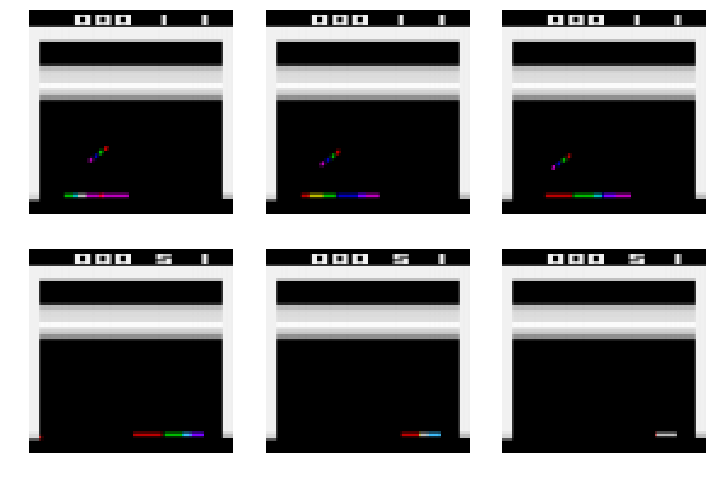

In [0]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("r_18_15")
plt.show()

Stwórzmy teraz zestaw danych:

In [0]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

Dla uzyskania lepszej wydajności przekształćmy główne funkcje w funkcje TF:

In [0]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

Jesteśmy w końcu gotowi na uruchomienie głównej pętli!

In [0]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} Funkcja straty:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

Następna komórka spowoduje uczenia agenta przez 10 000 kroków. Dzięki kolejnej komórce będziesz mógł sprawdzić działanie agenta. Możesz uruchamiać obydwie komórki dowolną liczbę razy. Za każdym razem agent będzie osiągał coraz lepsze wyniki!

In [0]:
train_agent(n_iterations=10000)

W0528 08:49:00.697262 140735810999168 deprecation.py:323] From /Users/ageron/miniconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py:409: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0528 08:49:01.475340 140735810999168 deprecation.py:323] From /Users/ageron/miniconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
I0528 08:49:02.463025 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


997 loss:0.01551

I0528 08:50:16.405580 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 4004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 180.5


2000 loss:0.00024

I0528 08:51:28.353239 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 8004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 165.89999389648438


2997 loss:0.00010

I0528 08:52:36.316717 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 69
		 EnvironmentSteps = 12004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 162.3000030517578


3999 loss:0.00751

I0528 08:53:47.764101 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 92
		 EnvironmentSteps = 16004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 161.89999389648438


4997 loss:0.00032

I0528 08:54:57.040647 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 111
		 EnvironmentSteps = 20004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 181.60000610351562


6000 loss:0.00006

I0528 08:56:07.210252 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 131
		 EnvironmentSteps = 24004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 206.39999389648438


6999 loss:0.00784

I0528 08:57:18.494511 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 154
		 EnvironmentSteps = 28004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 182.6999969482422


7997 loss:0.00002

I0528 08:58:35.320452 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 175
		 EnvironmentSteps = 32004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 196.60000610351562


8997 loss:0.00749

I0528 08:59:51.332596 140735810999168 metric_utils.py:47]  
		 NumberOfEpisodes = 195
		 EnvironmentSteps = 36004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 185.8000030517578


9999 loss:0.00001

In [0]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(1)
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

Jeżeli chcesz zapisać animowany obraz GIF, aby zademonstrować agenta znajomym, możesz to zrobić w następujący sposób:

In [0]:
import PIL

image_path = os.path.join("rysunki", "R18", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [0]:
%%html
<img src="rysunki/R18/breakout.gif" />

# Materiały dodatkowe

## Lista dwustronna a lista rotacyjna

Klasa `deque` zapewnia szybkie dodawanie elementów, ale dość powolny dostęp swobodny (w przypadku dużych pamięci odtwarzania):

In [0]:
from collections import deque
np.random.seed(42)

mem = deque(maxlen=1000000)
for i in range(1000000):
    mem.append(i)
[mem[i] for i in np.random.randint(1000000, size=5)]

[121958, 671155, 131932, 365838, 259178]

In [0]:
%timeit mem.append(1)

76.8 ns ± 0.31 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [0]:
%timeit [mem[i] for i in np.random.randint(1000000, size=5)]

320 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Ewentualnie możesz skorzystać z listy rotacyjnej, takiej jak klasa `ReplayMemory`. Dzięki temu dostęp swobodny w dużych pamięciach odtwarzania byłby szybszy.

In [0]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=np.object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [0]:
mem = ReplayMemory(max_size=1000000)
for i in range(1000000):
    mem.append(i)
mem.sample(5)

array([757386, 904203, 190588, 595754, 865356], dtype=object)

In [0]:
%timeit mem.append(1)

761 ns ± 17.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [0]:
%timeit mem.sample(5)

2.97 µs ± 16.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Tworzenie niestandardowego środowiska TF-Agents

Aby stworzyć niestandardowe środowisko TF-Agent wystarczy napisać klasę dziedziczącą z klasy `PyEnvironment` i implementującą kilka metod. Na przykład poniższe, minimalistyczne środowisko składa się z siatki 4x4. Agent rozpoczyna w jednym narożniku (0,0) i musi dotrzeć do przeciwległego narożnika (3,3). Epizod zostaje zakończony, jeżeli agent zrealizuje cel (dostanie nagrodę +10) lub jeżeli wyjdzie poza granice (nagroda -1). Możliwe czynności to ruch do góry (0), w dół (1), w lewo (2) i w prawo (3).

In [0]:
class MyEnvironment(tf_agents.environments.py_environment.PyEnvironment):
    def __init__(self, discount=1.0):
        super().__init__()
        self._action_spec = tf_agents.specs.BoundedArraySpec(
            shape=(), dtype=np.int32, name="czynnosc", minimum=0, maximum=3)
        self._observation_spec = tf_agents.specs.BoundedArraySpec(
            shape=(4, 4), dtype=np.int32, name="obserwacja", minimum=0, maximum=1)
        self.discount = discount

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros(2, dtype=np.int32)
        obs = np.zeros((4, 4), dtype=np.int32)
        obs[self._state[0], self._state[1]] = 1
        return tf_agents.trajectories.time_step.restart(obs)

    def _step(self, action):
        self._state += [(-1, 0), (+1, 0), (0, -1), (0, +1)][action]
        reward = 0
        obs = np.zeros((4, 4), dtype=np.int32)
        done = (self._state.min() < 0 or self._state.max() > 3)
        if not done:
            obs[self._state[0], self._state[1]] = 1
        if done or np.all(self._state == np.array([3, 3])):
            reward = -1 if done else +10
            return tf_agents.trajectories.time_step.termination(obs, reward)
        else:
            return tf_agents.trajectories.time_step.transition(obs, reward,
                                                               self.discount)

Specyfikacjami czynności i obserwacji będą zazwyczaj instancje klas `ArraySpec` lub `BoundedArraySpec` z pakietu `tf_agents.specs` (warto również sprawdzić zawarte w nim inne specyfikacje). Ewentualnie możesz także zdefiniować metodę `render()`, metodę `close()` do zwalniania zasobów, a także metodę `time_step_spec()`, jeśli nie chcesz aby wartości `reward` i `discount` były 32-bitowymi skalarami zmiennoprzecinkowymi. Zwróć uwagę, że klasa bazowa zajmuje się śledzeniem bieżącego taktu, dlatego właśnie musimy zaimplementować metody `_reset()` i `_step()` zamiast metod `reset()` i `step()`.


In [0]:
my_env = MyEnvironment()
time_step = my_env.reset()
time_step

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32))

In [0]:
time_step = my_env.step(1)
time_step

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32))